# Imports

In [2]:
import pandas as pd
import dill
import numpy as np
import random
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

Переменные:

In [3]:
path = 'data'

files = ['ga_hits.csv', 'ga_sessions.csv', 'ga_hits.pkl', 'ga_sessions.pkl']

target_actions = ['sub_car_claim_click', 'sub_car_claim_submit_click',
                    'sub_open_dialog_click', 'sub_custom_question_submit_click',
                    'sub_call_number_click', 'sub_callback_submit_click', 
                    'sub_submit_success', 'sub_car_request_submit_click'
                 ]

organic_traffic = ['organic','referral', '(none)']

social_media = {'QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 
                'ISrKoXQCxqqYvAZICvjs', 'IZEXUFLARCUMynmHNBGo', 
                'PlbkrSYoHuZBWfYjYnfw', 'gVRrcxiDQubJiljoTbGm'
               }

# Functions

In [4]:
# Вывод количества полностью заполенных объектов и их процент от выборки
def print_useful_rows_info(df):
    print('Количество полностью заполненных объектов из всей выборки:', len(df.dropna()))
    print('Процент полностью заполненных объектов из всей выборки:', round(len(df.dropna()) / len(df) * 100, 2))

In [5]:
# Вывод количества пропущенных значений и их процента в выборке
def missing_values_info(df, column=None):
    if column == None:
        missing_values = ((df.isna().sum() / len(df)) * 100).sort_values()
        print('Процент пропущенных значений:\n', missing_values)
    else:
        print(f' Количество пропущенных значений: {len(df[df[column].isna()])}')
        print(f' Процент в выборке: {round((len(df[df[column].isna()]) / len(df)) * 100, 2)}')


# Data loading

In [6]:
%%time
with open(f'{path}/{files[2]}', 'rb') as file:
    df_hits = dill.load(file)
    
with open(f'{path}/{files[3]}', 'rb') as file:
    df_sessions = dill.load(file)

Wall time: 31 s


In [7]:
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,None
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,None
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,None
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,None
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,None


In [8]:
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


# Data Preparation

## Описание данных

Узнаем размеры датафреймов.

In [9]:
df_hits.shape

(15726470, 11)

In [10]:
df_sessions.shape

(1860042, 18)

Выведем описательные статистики.

In [11]:
df_hits.describe(include='all')

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
count,15726470,15726470,6.566148e+06,1.572647e+07,15726470,9451666,15726470,15726470,15726470,11966286,0
unique,1734610,226,NaN,NaN,1,37873,342715,52,230,39825,0
top,5442565791571325612.1632449195.1632449195,2021-05-24,NaN,NaN,event,HbolMJUevblAbkHClEQa,podpiska.sberauto.com/,card_web,view_card,KclpemfoHstknWHFiLit,NaN
freq,768,513035,NaN,NaN,15726470,8879187,2793639,7456998,3558985,6505447,NaN
mean,NaN,NaN,2.091050e+05,2.356715e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,4.032110e+05,2.887713e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000e+00,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,2.412000e+04,7.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,8.994100e+04,1.500000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.195352e+05,2.900000e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
df_sessions.describe(include='all')

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
count,1860042,1860042,1860042,1860042,1.860042e+06,1859945,1860042,1640439,1524427,777981,1860042,789904,1741364,16338,1860042,1860042,1860042,1860042
unique,1860042,1391719,226,85318,NaN,293,56,412,286,1219,3,13,206,104,5039,57,166,2548
top,9055434745589932991.1637753792.1637753792,1750498477.1629450062,2021-05-24,12:00:00,NaN,ZpYIoDJMcFzVoPFsHGJL,banner,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Apple,AuMdmADEIoPXiWpTsBEj,414x896,Chrome,Russia,Moscow
freq,1,462,39453,61067,NaN,578290,552272,463481,1006599,506819,1474871,464054,551088,9778,169090,1013436,1800565,805329
mean,NaN,NaN,NaN,NaN,2.712804e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.182907e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,2.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Проверим типы данных.

In [13]:
df_hits.dtypes

session_id         object
hit_date           object
hit_time          float64
hit_number          int64
hit_type           object
hit_referer        object
hit_page_path      object
event_category     object
event_action       object
event_label        object
event_value        object
dtype: object

In [14]:
df_sessions.dtypes

session_id                  object
client_id                   object
visit_date                  object
visit_time                  object
visit_number                 int64
utm_source                  object
utm_medium                  object
utm_campaign                object
utm_adcontent               object
utm_keyword                 object
device_category             object
device_os                   object
device_brand                object
device_model                object
device_screen_resolution    object
device_browser              object
geo_country                 object
geo_city                    object
dtype: object

Выведем атрибуты наших таблиц.

In [15]:
for i in df_hits.columns:
    print(i)

session_id
hit_date
hit_time
hit_number
hit_type
hit_referer
hit_page_path
event_category
event_action
event_label
event_value


In [16]:
for i in df_sessions.columns:
    print(i)

session_id
client_id
visit_date
visit_time
visit_number
utm_source
utm_medium
utm_campaign
utm_adcontent
utm_keyword
device_category
device_os
device_brand
device_model
device_screen_resolution
device_browser
geo_country
geo_city


Узнаем все общие атрибуты датафреймов.

In [17]:
print(set(df_hits.columns) & set(df_sessions.columns))

{'session_id'}


## Объединение таблиц

Для выполнения задачи, из таблицы `hits` интересует только информация о том, было ли достигнуто "целевое событие" типа «Оставить заявку» и «Заказать звонок». Добавим в таблицу новый атрибут `target`, в котором укажем "1", при наличии целевого события, и "0", при его отсутствии.

In [18]:
%%time
df_hits['target'] = df_hits.apply(lambda x: 1 if x.event_action in target_actions else 0, axis=1)

Wall time: 1min 55s


Проверим, что получилось

In [19]:
df_hits.target.value_counts()

0    15621562
1      104908
Name: target, dtype: int64

Нас интересуют только было ли целевое событие в определенную сессию или нет. Поэтому уберем все лишнее и избавимся от дубликатов. Оставим только уникальные значения в `session_id` и наш `target`, который показывает - было целевое событие в данную сессию или нет.

In [20]:
pivot_table = pd.pivot_table(df_hits, index=['session_id'], values=['target'], 
                             aggfunc={'target': [lambda x: 0 if x.sum() == 0 else 1]})
pivot_table

,target
,<lambda>
session_id,
1000009318903347362.1632663668.1632663668,0
1000010177899156286.1635013443.1635013443,0
1000013386240115915.1635402956.1635402956,0
1000017303238376207.1623489300.1623489300,0
1000020580299877109.1624943350.1624943350,0
...,...
999960188766601545.1626816843.1626816843,0
99996598443387715.1626811203.1626811203,0


In [21]:
df_hits_duplicate = pivot_table.reset_index(level=0)
df_hits_duplicate

,session_id,target
,,<lambda>
0,1000009318903347362.1632663668.1632663668,0
1,1000010177899156286.1635013443.1635013443,0
2,1000013386240115915.1635402956.1635402956,0
3,1000017303238376207.1623489300.1623489300,0
4,1000020580299877109.1624943350.1624943350,0
...,...,...
1734605,999960188766601545.1626816843.1626816843,0
1734606,99996598443387715.1626811203.1626811203,0
1734607,999966717128502952.1638428330.1638428330,0


In [22]:
df_hits_duplicate.columns = ['session_id', 'target']
df_hits_duplicate

,session_id,target
0,1000009318903347362.1632663668.1632663668,0
1,1000010177899156286.1635013443.1635013443,0
2,1000013386240115915.1635402956.1635402956,0
3,1000017303238376207.1623489300.1623489300,0
4,1000020580299877109.1624943350.1624943350,0
...,...,...
1734605,999960188766601545.1626816843.1626816843,0
1734606,99996598443387715.1626811203.1626811203,0
1734607,999966717128502952.1638428330.1638428330,0
1734608,999988617151873171.1623556243.1623556243,0


Проверим, все ли строки теперь уникальны.

In [23]:
df_hits_duplicate.session_id.describe()

count                                       1734610
unique                                      1734610
top       1000009318903347362.1632663668.1632663668
freq                                              1
Name: session_id, dtype: object

Проверим корректность преобразования в столбце `target`

In [24]:
df_hits_duplicate.target.value_counts()

0    1683850
1      50760
Name: target, dtype: int64

Узнаем размер, получившейся таблицы

In [25]:
df_hits_duplicate.shape

(1734610, 2)

выведем количество строк в датасете `df_sessions`

In [26]:
df_sessions.shape

(1860042, 18)

Посмотрим, есть ли различия в столбцах `session_id` у объединяемых таблиц

In [27]:
len(set(df_sessions.session_id) - set(df_hits_duplicate.session_id))

127776

In [28]:
len(set(df_hits_duplicate.session_id) - set(df_sessions.session_id))

2344

Посмотрим сколько общих строк в столбце `session_id` объединяемых таблиц

In [29]:
len(set(df_sessions.session_id) & set(df_hits_duplicate.session_id))

1732266

Датафрейм `df_sessions` содержит 127 776 уникальных сессий, а `df_hits_duplicate` - 2 344. Общих - 1 732 266.
Для получения качественной модели с хорошей предсказательной способностью, оставим только те сущности, у которых имеются все атрибуты, предполагающиеся на вход будущей модели, и известна целевая переменная. Потеря данных составит около 7% сущностей, не попавших под наши критерии.
Объединим таблицы методом `inner`.

In [30]:
%%time
df = df_sessions.join(df_hits_duplicate.set_index('session_id'), on='session_id', how='inner')
df

Wall time: 3.19 s


,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,None,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,VlqBmecIOXWjCWUmQkLd,desktop,Windows,None,NaN,1920x1080,Chrome,Russia,Moscow,0
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,NaN,mobile,None,Apple,NaN,390x844,Safari,Russia,Stavropol,0
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,iOS,Apple,NaN,375x667,Safari,Russia,Moscow,0
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,puhZPIYqKXeFPaUviSjo,mobile,Android,Xiaomi,NaN,393x851,Chrome,Russia,Chelyabinsk,0


## Data cleaning

### Обработка пропусков в данных

Выведим количество и процент полностью заполненных объектов из всей выборки.

In [31]:
print_useful_rows_info(df)

Количество полностью заполненных объектов из всей выборки: 13829
Процент полностью заполненных объектов из всей выборки: 0.8


Выведим процент пропущенных значений по каждому атрибуту.

In [32]:
missing_values = missing_values_info(df)

Процент пропущенных значений:
 session_id                   0.000000
geo_country                  0.000000
device_browser               0.000000
device_screen_resolution     0.000000
device_category              0.000000
geo_city                     0.000000
target                       0.000000
visit_number                 0.000000
visit_time                   0.000000
visit_date                   0.000000
client_id                    0.000000
utm_medium                   0.000000
utm_source                   0.004387
device_brand                 6.358030
utm_campaign                11.273500
utm_adcontent               17.557177
device_os                   58.533966
utm_keyword                 58.925823
device_model                99.130503
dtype: float64


Представим визуальный график заполненных значений

<AxesSubplot:>

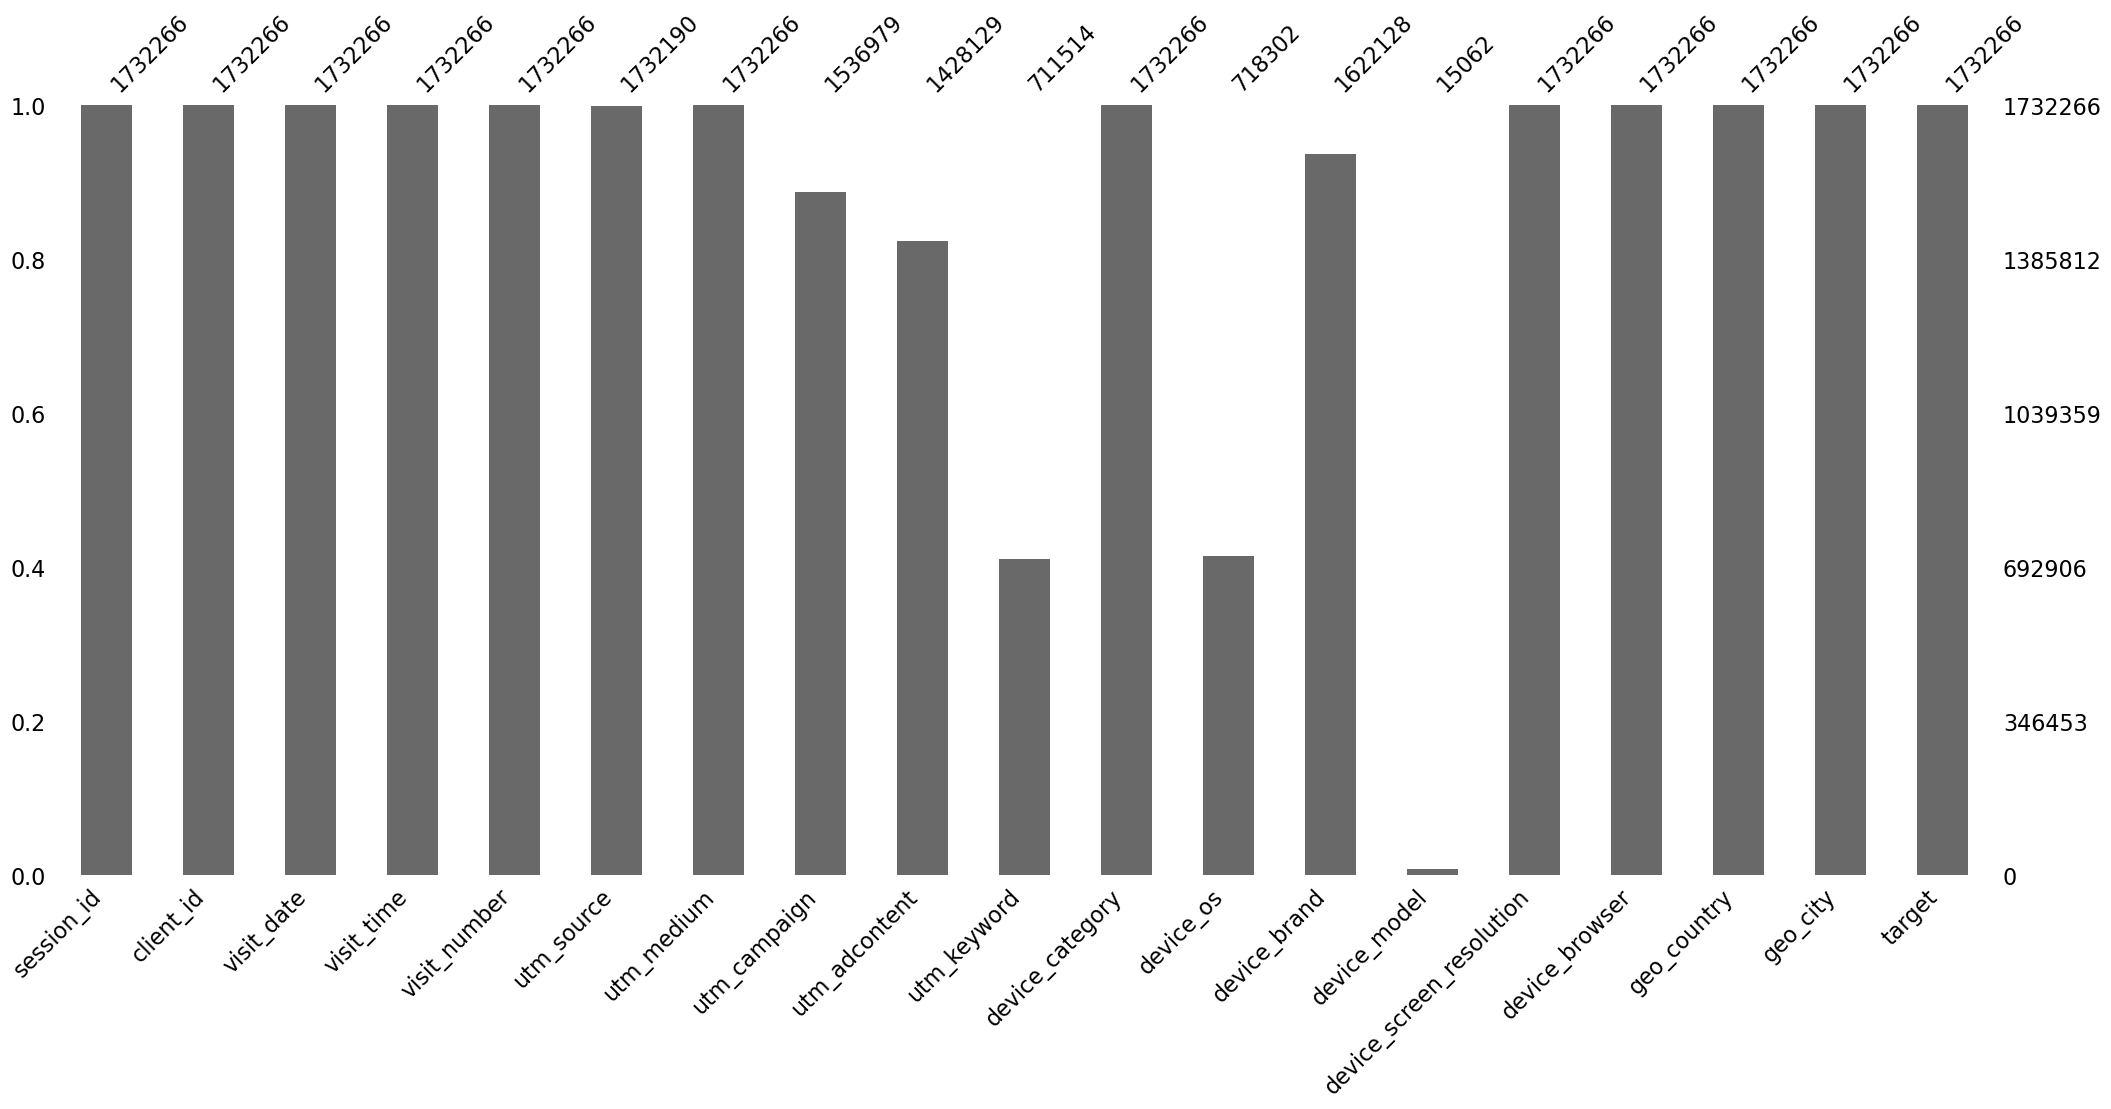

In [33]:
msno.bar(df)

Выведем матрицу пропусков.

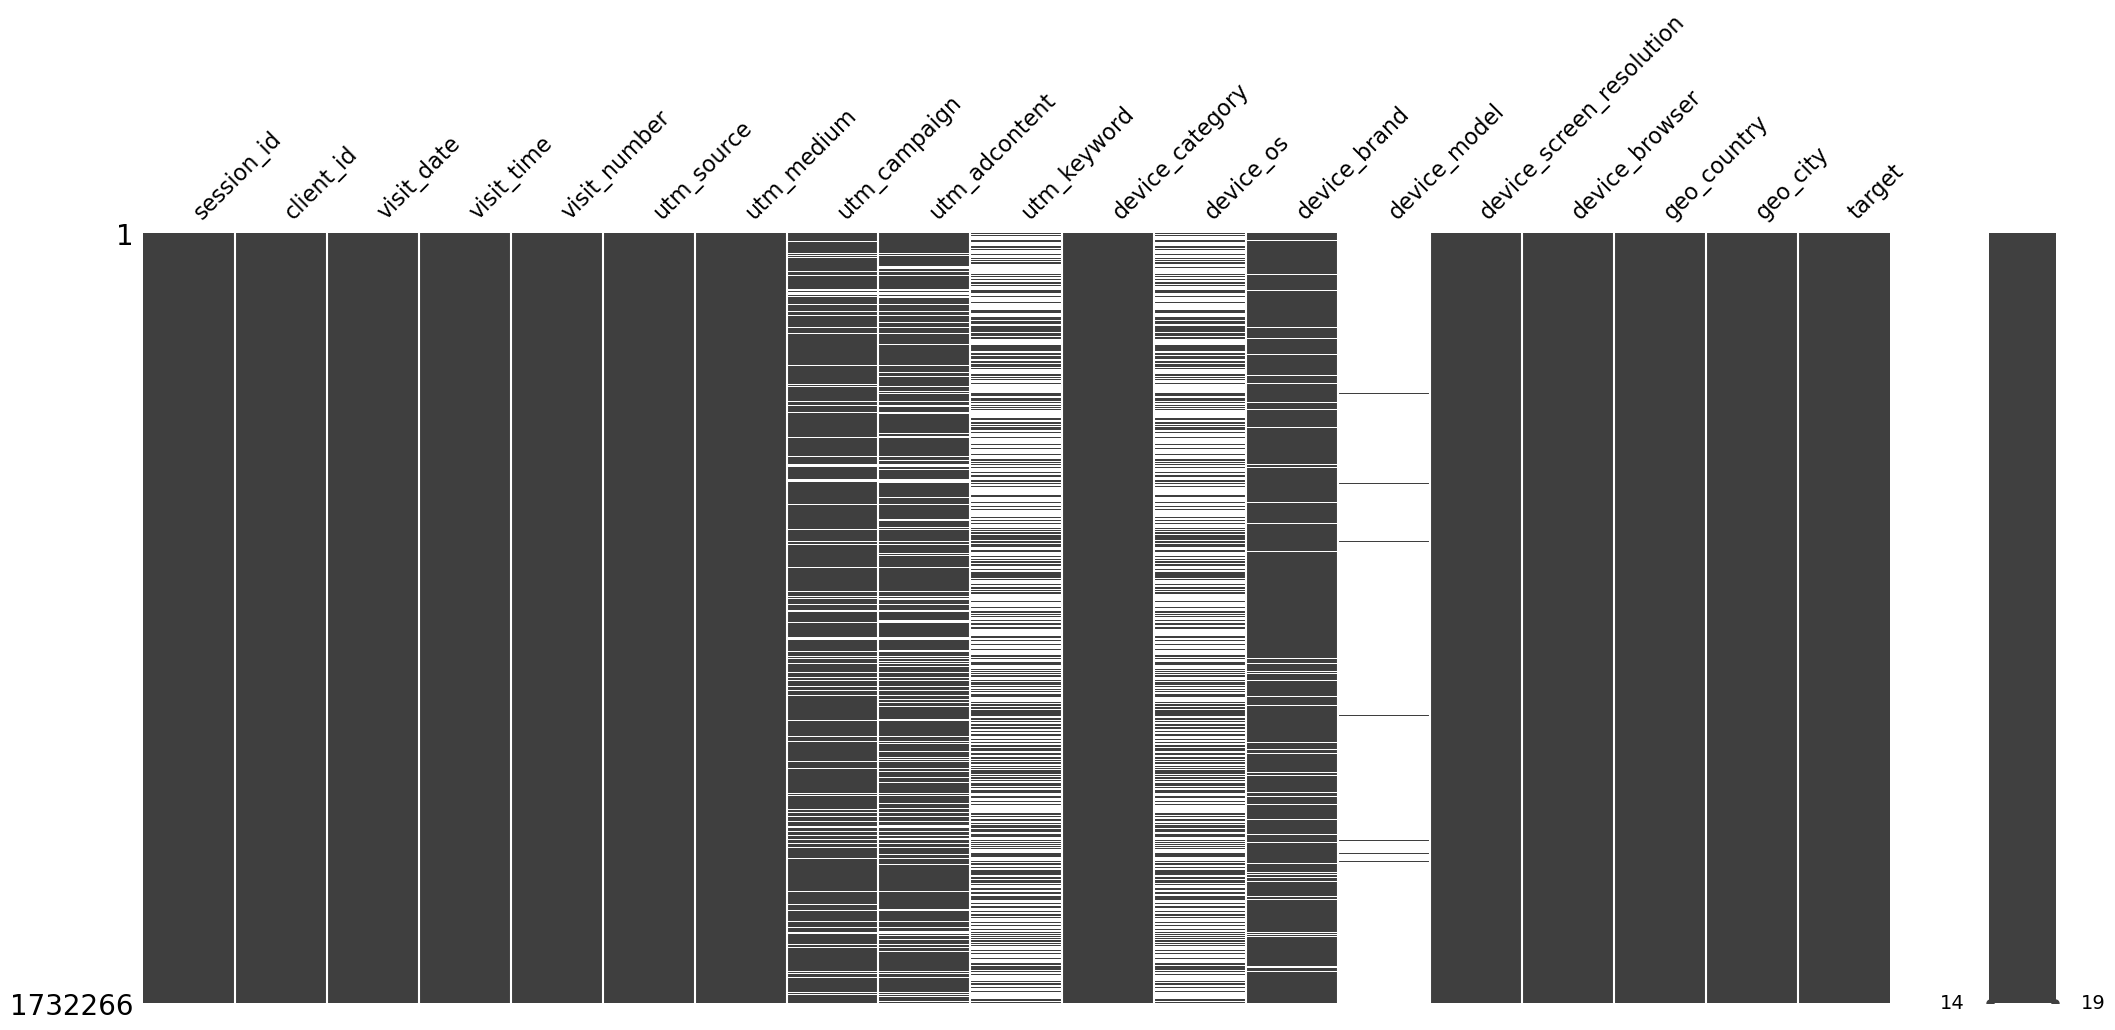

In [34]:
msno.matrix(df);

#### `device_model`, `utm_keyword`, `device_os`

Данный столбцы не информативны, так как процент их заполненности меньше 50%. Удалим эти столбцы.

In [35]:
df_cleaned = df.drop(['device_model', 'utm_keyword', 'device_os'], axis=1)
df_cleaned

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860037,9055415581448263752.1640159305.1640159305,2108378238.1640159304,2021-12-22,10:48:25,1,BHcvLfOaCWvWTykYqHVe,cpc,NaN,NaN,desktop,None,1920x1080,Chrome,Russia,Moscow,0
1860038,9055421130527858185.1622007305.1622007305,2108379530.1622007305,2021-05-26,08:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,390x844,Safari,Russia,Stavropol,0
1860039,9055422955903931195.1636979515.1636979515,2108379955.1636979515,2021-11-15,15:31:55,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Apple,375x667,Safari,Russia,Moscow,0
1860040,905543020766873816.1638189404.1638189404,210838164.1638189272,2021-11-29,15:36:44,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Xiaomi,393x851,Chrome,Russia,Chelyabinsk,0


#### `device_brand`

Выведем количество пропусков в колонке `device_brand` и их процент от всей выборки.

In [36]:
missing_values_info(df_cleaned, 'device_brand')

 Количество пропущенных значений: 110138
 Процент в выборке: 6.36


Выведим список всех значений столбца `device_brand`.

In [37]:
df_cleaned.device_brand.unique().tolist()

['Huawei',
 'Samsung',
 'Xiaomi',
 'Apple',
 'Lenovo',
 None,
 'Vivo',
 'Meizu',
 '',
 'OnePlus',
 '(not set)',
 'BQ',
 'Realme',
 'OPPO',
 'itel',
 'Philips',
 'Nokia',
 'Alcatel',
 'LG',
 'Tecno',
 'Asus',
 'Infinix',
 'Sony',
 'ZTE',
 'Wiko',
 'Google',
 'Micromax',
 'Blackview',
 'Oukitel',
 'Motorola',
 'HOMTOM',
 'Cubot',
 'DOOGEE',
 'China Phone',
 'DEXP',
 'Neffos',
 'TP-Link',
 'Hisense',
 'Acer',
 'Vsmart',
 'BlackBerry',
 'Umidigi',
 'Leagoo',
 'Highscreen',
 'Ulefone',
 'Symphony',
 'LeEco',
 'Prestigio',
 'POCO',
 'Vestel',
 'Guophone',
 'Wileyfox',
 'HTC',
 'Vertex',
 'CAT',
 'InFocus',
 'TCL',
 'SonyEricsson',
 'Inoi',
 'Nomu',
 'Jiake',
 'ZOJI',
 'Mozilla',
 'Tele2',
 'H96',
 'Kyocera',
 'Karbonn',
 'BLU',
 'Haier',
 'Kingplay',
 'Sharp',
 'Coolpad',
 'MTC',
 'LeTV',
 'iNew',
 'Vernee',
 'A1',
 'Gionee',
 'General Mobile',
 'Digma',
 'Yota Devices',
 'Gome',
 'Egreat',
 'Kata',
 'Mito',
 'Poptel',
 'Flylion',
 'AGM',
 'SenseIT',
 'Archos',
 'Teclast',
 'Fly',
 'MLS',
 '

Как мы видим, помимо пустых значений None в столбце имеются еще неинформативные значения " ". Посчитаем их. 

In [38]:
len(df_cleaned[df_cleaned.device_brand == ''])

237058

Посмотрим к какой категории относятся пустые значения None и ''.

In [39]:
df_cleaned[(df_cleaned.device_brand.isna()) | (df_cleaned.device_brand == '')].device_category.value_counts(dropna=False)

desktop    346752
mobile        288
tablet        156
Name: device_category, dtype: int64

Узнаем, сколько всего строк с категорией desktop

In [40]:
len(df_cleaned[df.device_category == 'desktop'])

346891

In [41]:
df_cleaned[df.device_category == 'desktop'][(df_cleaned.device_brand.notna()) & (df_cleaned.device_brand != '')].device_brand.unique().tolist()

C:\Users\1\AppData\Local\Temp\ipykernel_17792\3874192751.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cleaned[df.device_category == 'desktop'][(df_cleaned.device_brand.notna()) & (df_cleaned.device_brand != '')].device_brand.unique().tolist()


['Apple',
 'Xiaomi',
 'Samsung',
 'Huawei',
 'Flexymove',
 'Nokia',
 'Google',
 '(not set)',
 'Asus',
 'Beelink',
 'OPPO',
 'OnePlus',
 'Philips',
 'Realme']

Посмотрим какой у них браузер

In [42]:
df_cleaned[df_cleaned.device_brand.isna()].device_browser.value_counts(dropna=False)

Chrome                              63652
YaBrowser                           19205
Safari                              12660
Edge                                 5787
Firefox                              4840
Opera                                3530
Mozilla Compatible Agent              285
Samsung Internet                      100
MRCHROME                               23
Internet Explorer                       8
helloworld                              6
[FBAN                                   6
Instagram 212.0.0.38.119 Android        6
Maxthon                                 5
(not set)                               5
Instagram 216.1.0.21.137 Android        4
Instagram 213.0.0.29.120 Android        4
Android                                 3
Puffin                                  3
Coc Coc                                 2
UC Browser                              2
SeaMonkey                               1
Mozilla                                 1
Name: device_browser, dtype: int64

Как мы видим, марка устройства не указана практически во всех объектах категории 'desktop'.
Скорее всего это связано с тем, что зачастую настольный компьютер не имеет определенного производителя, так как состоит из комплектующих разных производителей. Заменим пропуски на значение `other`.

In [43]:
df_cleaned.device_brand = df_cleaned.device_brand.fillna('other')

In [44]:
df_cleaned.loc[df_cleaned['device_brand'] == '', 'device_brand'] = 'other'

Проверим, остались ли пустые строки в столбце `device_brand`

In [45]:
len(df_cleaned.loc[df_cleaned['device_brand'] == '', 'device_brand'])

0

#### `utm_source`

Выведем количество пропущенных значений и процент их в выборке

In [46]:
missing_values_info(df_cleaned, 'utm_source')

 Количество пропущенных значений: 76
 Процент в выборке: 0.0


Процент пропущенных значений в столбце `utm_source` близок нулю, удалим строки с пропущенными значениями.

In [47]:
df_cleaned = df_cleaned[df_cleaned.utm_source.notna()]

#### `utm_campaign`

Выведем количество пропущенных значений и их процент в выборке

In [48]:
missing_values_info(df_cleaned, 'utm_campaign')

 Количество пропущенных значений: 195287
 Процент в выборке: 11.27


Выведем количество значений и описательные статистики

In [49]:
df_cleaned.utm_campaign.value_counts(dropna=False)

LTuZkdKfxRGVceoWkVyg    422965
LEoPHuyFvzoNfnzGgfcd    321286
FTjNLDyTrXaWYgZymFkV    234950
NaN                     195287
gecBYcKZCPMcVYdSSzKP    133247
                         ...  
qPDTdivQVeflLjTYIJnG         1
InOGyxvxAfYvSHCpIjJZ         1
ehLonfPENrOEoPTIyiOZ         1
YlsczTIyBSwTLNtuDkCd         1
cXxuwXPoQCvAXPHpFcZl         1
Name: utm_campaign, Length: 407, dtype: int64

In [50]:
df_cleaned.utm_campaign.describe()

count                  1536903
unique                     406
top       LTuZkdKfxRGVceoWkVyg
freq                    422965
Name: utm_campaign, dtype: object

In [51]:
422965/1536903*100

27.520604748640608

Пропущенных значений больше 10%, достаточно много чтобы удалить. В то же время есть частое значение, которое встречается в трети случаев. Разные рекламные кампании могли по разному себя показать и если заполнить пропуски модой, то можно случайно дать одной кампании больше веса при расчете модели, либо наоборот. Поэтому заполним пропущенные значения, значением 'other'.

In [52]:
df_cleaned.loc[df_cleaned.utm_campaign.isna(), 'utm_campaign'] = 'other'

In [53]:
missing_values_info(df_cleaned, 'utm_campaign')

 Количество пропущенных значений: 0
 Процент в выборке: 0.0


#### `utm_adcontent`

In [54]:
missing_values_info(df_cleaned, 'utm_adcontent')

 Количество пропущенных значений: 304101
 Процент в выборке: 17.56


Выведим количество значений и описательные статистики

In [55]:
df_cleaned.utm_adcontent.value_counts(dropna=False)

JNHcPlZPxEMWDnRiyoBf    935368
NaN                     304101
vCIpmpaGBnIQhyYNkXqp    179438
xhoenQgDQsgfEPYNPwKO    104381
PkybGvWbaqORmxjNunqZ     59038
                         ...  
zQEFTgQvqExfbldEpotc         1
JgmeMvxiYyrYlmqauiSv         1
aVjToAjFPhYtOzTWvULR         1
QMmfrhgnqNOwSTPaqlLK         1
oJivRDNIrrOckRBIKOtG         1
Name: utm_adcontent, Length: 281, dtype: int64

In [56]:
df_cleaned.utm_adcontent.describe()

count                  1428089
unique                     280
top       JNHcPlZPxEMWDnRiyoBf
freq                    935368
Name: utm_adcontent, dtype: object

Выведем записи, где атрибут не заполнен

In [57]:
df_cleaned[df_cleaned.utm_adcontent.isna()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,other,NaN,mobile,Xiaomi,393x786,Chrome,Russia,Moscow,0
14,9055469620715506713.1636559415.1636559415,2108390820.1628883993,2021-11-10,18:50:15,4,SzZERoLMmrEUEhDaYcyN,cpc,other,NaN,mobile,Samsung,412x869,Android Webview,Russia,Saint Petersburg,0
27,9055504865227535872.1639282176.1639282176,2108399026.1639282176,2021-12-12,07:09:36,1,BHcvLfOaCWvWTykYqHVe,cpc,other,NaN,mobile,Samsung,385x854,Chrome,Russia,Moscow,0
37,905553874150070422.1639028885.1639028885,210840691.1639028886,2021-12-09,08:48:05,1,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,NaN,mobile,Apple,375x812,Safari,Russia,Moscow,0
39,905553874150070422.1639041598.1639041598,210840691.1639028886,2021-12-09,12:19:58,4,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,NaN,mobile,Apple,375x812,Safari,Russia,Moscow,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860018,9055329372850890545.1626351420.1626351420,2108358166.1626351409,2021-07-15,15:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,other,NaN,desktop,other,1920x1080,YaBrowser,Russia,Moscow,0
1860020,9055329372850890545.1629287172.1629287172,2108358166.1626351409,2021-08-18,14:00:00,3,BHcvLfOaCWvWTykYqHVe,cpc,other,NaN,desktop,other,1920x1080,YaBrowser,Russia,Moscow,0
1860031,9055387664158410361.1637729914.1637729914,2108371738.1637729913,2021-11-24,07:58:34,1,kjsLglQLzykiRbcDiGcD,cpc,RoDitORHdzGfGhNCyEMy,NaN,mobile,Apple,428x926,Safari,Russia,Moscow,0
1860035,9055398929844789828.1624891784.1624891784,2108374361.1624891972,2021-06-28,17:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,vXsFkagGabkcWKlgLzSg,NaN,mobile,Samsung,320x676,Chrome,Russia,Naro-Fominsk,0


В техническом задании нет описания данного атрибута, предположим, что он указывает на использование плагина "adcontent" для размещения объявлений. В таком случае пропуски означают, что пользователь привлечен без использования плагина. Заполним пропуски значением '(none)

In [58]:
df_cleaned.loc[df_cleaned.utm_adcontent.isna(), 'utm_adcontent'] = '(none)'

In [59]:
missing_values_info(df_cleaned, 'utm_adcontent')

 Количество пропущенных значений: 0
 Процент в выборке: 0.0


Проверим, остались ли еще пропущенные значения.

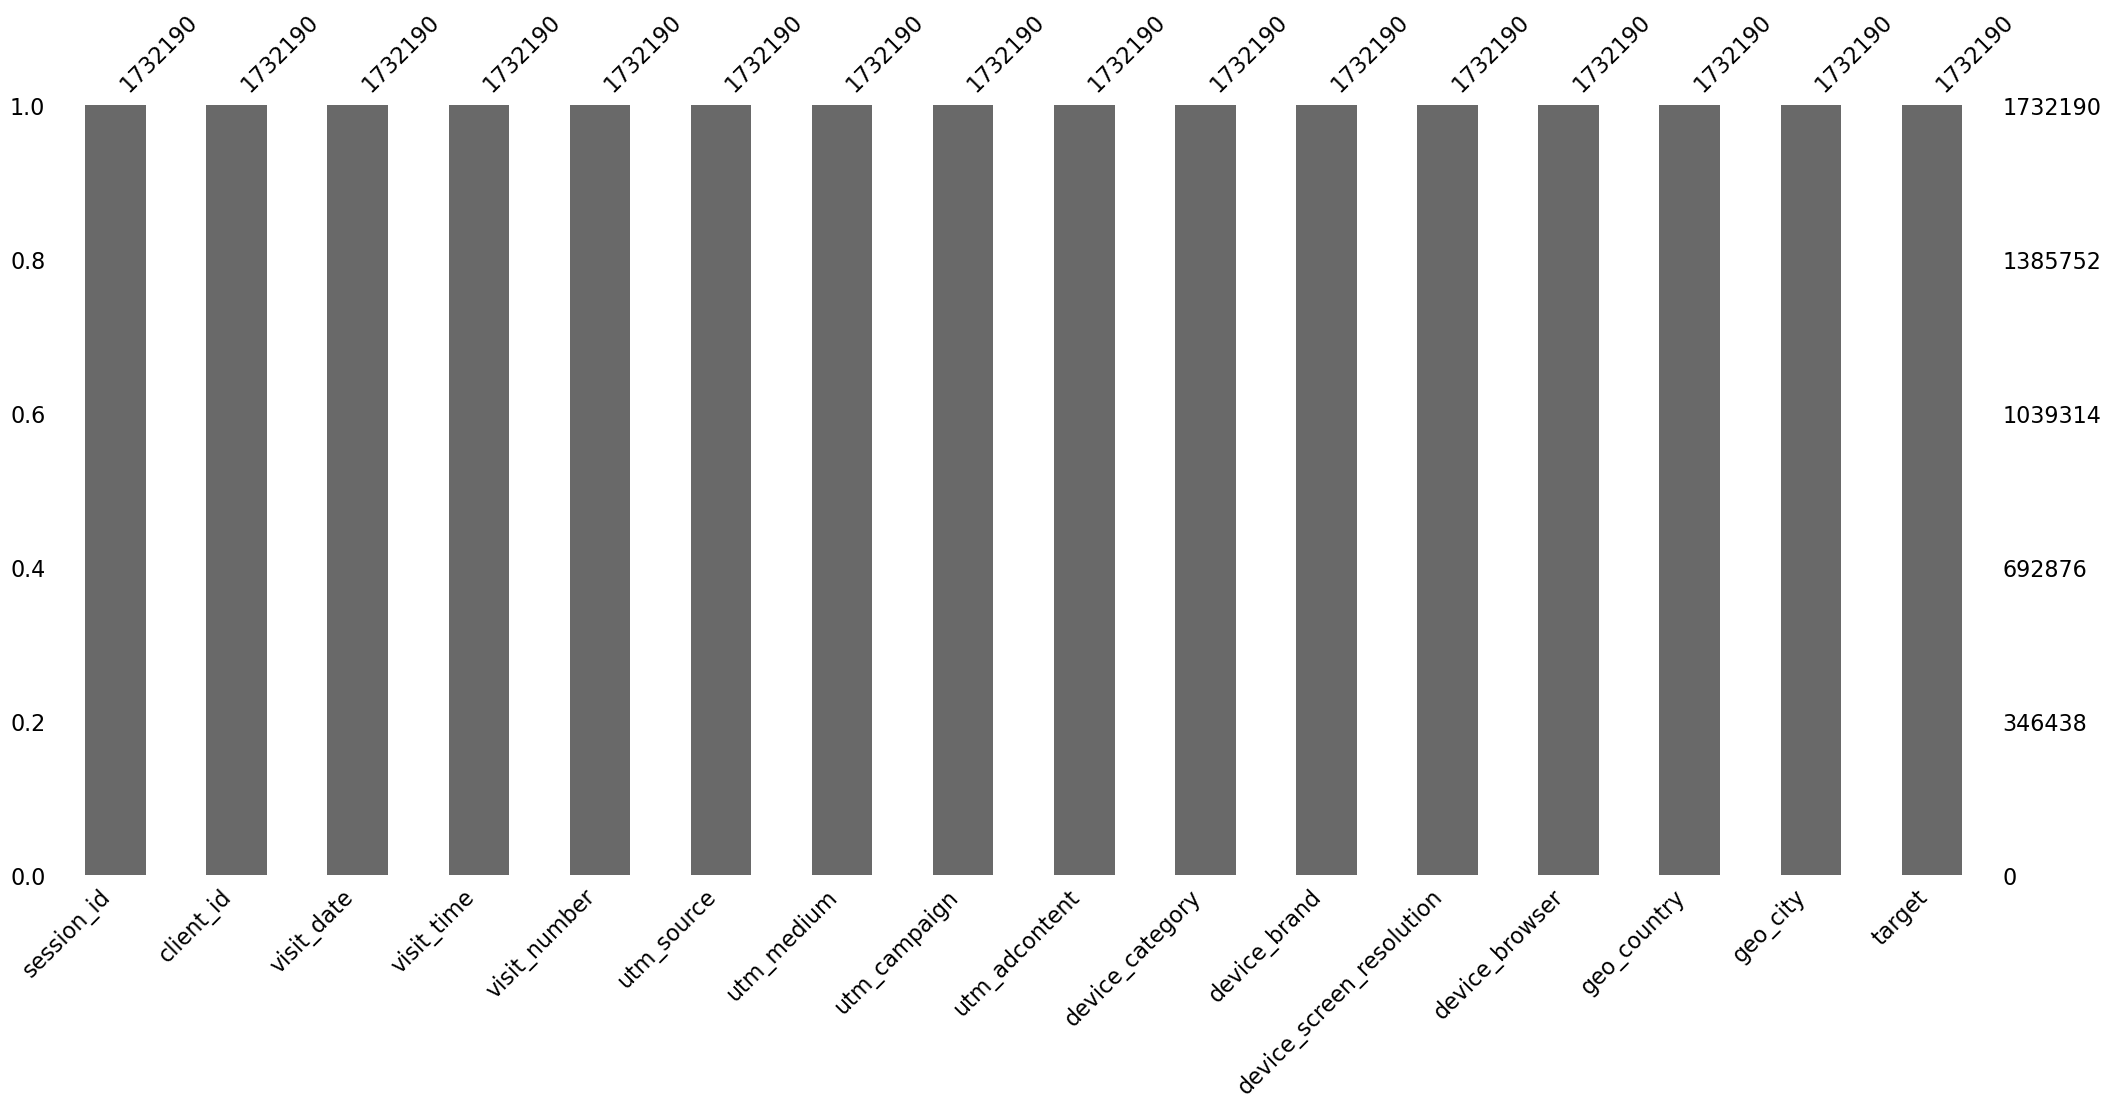

In [60]:
msno.bar(df_cleaned);

In [61]:
missing_values_info(df_cleaned)

Процент пропущенных значений:
 session_id                  0.0
client_id                   0.0
visit_date                  0.0
visit_time                  0.0
visit_number                0.0
utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
utm_adcontent               0.0
device_category             0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
target                      0.0
dtype: float64


### Устранение дубликатов

Проверим, имеются ли бублирующиеся значения.

In [62]:
df_cleaned[df_cleaned.duplicated()]

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target


Дублирующихся значений нет.

### Преобразование типов данных

Проверим типы данных

In [63]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732190 entries, 0 to 1860041
Data columns (total 16 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   session_id                object
 1   client_id                 object
 2   visit_date                object
 3   visit_time                object
 4   visit_number              int64 
 5   utm_source                object
 6   utm_medium                object
 7   utm_campaign              object
 8   utm_adcontent             object
 9   device_category           object
 10  device_brand              object
 11  device_screen_resolution  object
 12  device_browser            object
 13  geo_country               object
 14  geo_city                  object
 15  target                    int64 
dtypes: int64(2), object(14)
memory usage: 224.7+ MB


In [64]:
df_cleaned.iloc[0]

session_id                  9055434745589932991.1637753792.1637753792
client_id                                       2108382700.1637753791
visit_date                                                 2021-11-24
visit_time                                                   14:36:32
visit_number                                                        1
utm_source                                       ZpYIoDJMcFzVoPFsHGJL
utm_medium                                                     banner
utm_campaign                                     LEoPHuyFvzoNfnzGgfcd
utm_adcontent                                    vCIpmpaGBnIQhyYNkXqp
device_category                                                mobile
device_brand                                                   Huawei
device_screen_resolution                                      360x720
device_browser                                                 Chrome
geo_country                                                    Russia
geo_city            

Столбцы 'visit_date' и 'visit_time' содержат дату и время визита клиента, но имеют тип данных 'object'. Проверим, имеют ли они тип 'datetime', попробуем вывести день и час первой строки.

In [65]:
df_cleaned.visit_date[0].day

24

In [66]:
df_cleaned.visit_time[0].hour

14

Выведем значения в колонке 'visit_date'

In [67]:
df_cleaned.visit_date.values.tolist()

[datetime.date(2021, 11, 24),
 datetime.date(2021, 11, 14),
 datetime.date(2021, 12, 28),
 datetime.date(2021, 5, 29),
 datetime.date(2021, 5, 29),
 datetime.date(2021, 5, 31),
 datetime.date(2021, 12, 30),
 datetime.date(2021, 7, 12),
 datetime.date(2021, 12, 3),
 datetime.date(2021, 6, 27),
 datetime.date(2021, 8, 20),
 datetime.date(2021, 8, 13),
 datetime.date(2021, 10, 1),
 datetime.date(2021, 11, 2),
 datetime.date(2021, 11, 10),
 datetime.date(2021, 10, 14),
 datetime.date(2021, 11, 27),
 datetime.date(2021, 9, 1),
 datetime.date(2021, 11, 1),
 datetime.date(2021, 11, 28),
 datetime.date(2021, 10, 5),
 datetime.date(2021, 10, 12),
 datetime.date(2021, 10, 12),
 datetime.date(2021, 10, 12),
 datetime.date(2021, 10, 14),
 datetime.date(2021, 10, 14),
 datetime.date(2021, 6, 21),
 datetime.date(2021, 12, 12),
 datetime.date(2021, 12, 2),
 datetime.date(2021, 7, 8),
 datetime.date(2021, 7, 8),
 datetime.date(2021, 12, 1),
 datetime.date(2021, 8, 8),
 datetime.date(2021, 8, 8),
 date

In [68]:
df_cleaned.visit_date

0          2021-11-24
1          2021-11-14
2          2021-12-28
3          2021-05-29
4          2021-05-29
              ...    
1860037    2021-12-22
1860038    2021-05-26
1860039    2021-11-15
1860040    2021-11-29
1860041    2021-12-31
Name: visit_date, Length: 1732190, dtype: object

Типы данных приведены верно, преобразований не требуется.

# Data visualization

По заданию необходимо ознакомиться с распределением ключевых атрибутов.
Ключевыми атрибутами являются все атрибуты, типа `utm_*`, `device_*`, `geo_*`.

Выведем список ключевых аттрибутов

In [69]:
key_cols = []
for i in df_cleaned.columns.tolist():
    if i[:3] in ['utm', 'dev', 'geo']:
        key_cols.append(i)
key_cols        

['utm_source',
 'utm_medium',
 'utm_campaign',
 'utm_adcontent',
 'device_category',
 'device_brand',
 'device_screen_resolution',
 'device_browser',
 'geo_country',
 'geo_city']

Согласно заданию, имеет значение отношение канала привлечения к социальным сетям. Добавим столбец вида канала привлечения `advertising` и построим график соотношения количества привлеченных клиентов из социальных сетей к остальным клиентам.

In [70]:
df_cleaned['advertising'] = df_cleaned.apply(
    lambda x: 'social_media' if x.utm_source in social_media else 'other', axis=1)

C:\Users\1\AppData\Local\Temp\ipykernel_17792\165005367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['advertising'] = df_cleaned.apply(


Для быстрого создания столбчатых диаграмм, напишем небольшую функцию.

In [137]:
def bar_graf(df, column, xlabel, title, ylabel='частота'):
    
    pivot = df.groupby([column], as_index=False)['session_id'].count()
    pivot = pivot.rename(columns={'session_id': 'count'})
    pivot['percent'] = round(pivot['count'] / pivot['count'].sum() * 100, 1)
    print(pivot)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 8), nrows=1, ncols=2)
    
    ax1.bar(pivot[column], pivot['count'], color=['green', 'red'])
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
    ax2.bar(pivot[column], pivot['percent'], color=['green', 'red'])
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel(f'{ylabel} в %')   
    
    fig.suptitle(title)

    advertising    count  percent
0         other  1475910     85.2
1  social_media   256280     14.8


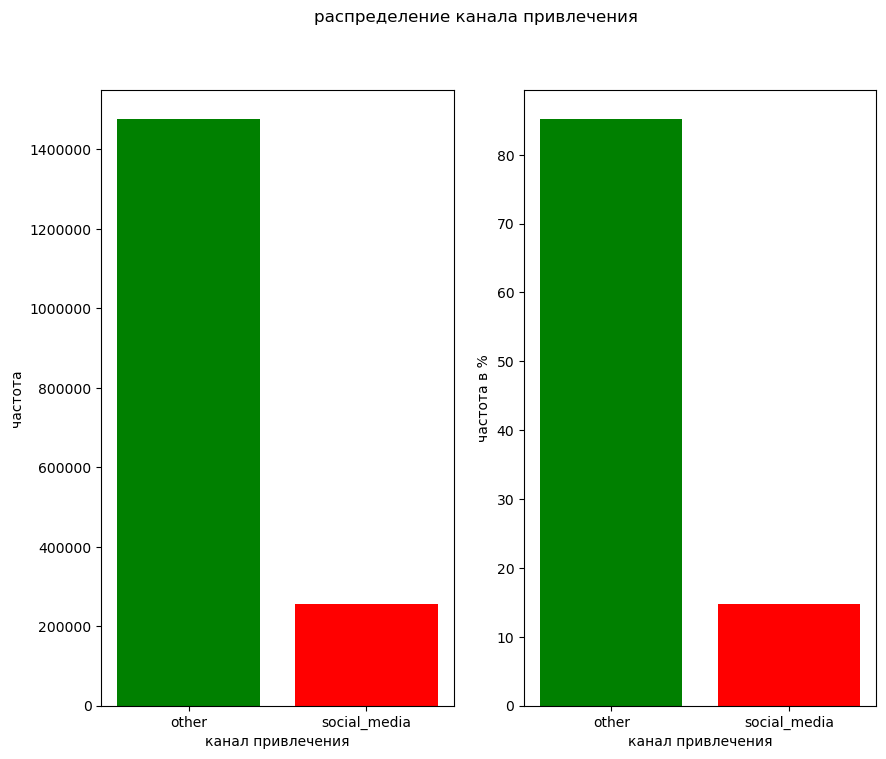

In [138]:
bar_graf(df=df_cleaned, 
         column='advertising', 
         xlabel='канал привлечения', 
         title='распределение канала привлечения', 
         ylabel='частота')

_Согласно графику, около 15 процентов клиентов были привлечены через социальные сети._

Техническим заданием по типу привлечения клиентов трафик делаится на органический и платный. 
Построим столбчатую диаграмму их соотношения.

In [135]:
df_cleaned['traffic'] = df_cleaned.apply(
    lambda x: 'organic' if x.utm_medium in organic_traffic else 'paid', axis=1)

C:\Users\1\AppData\Local\Temp\ipykernel_17792\198086332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['traffic'] = df_cleaned.apply(


   traffic    count  percent
0  organic   468920     27.1
1     paid  1263270     72.9


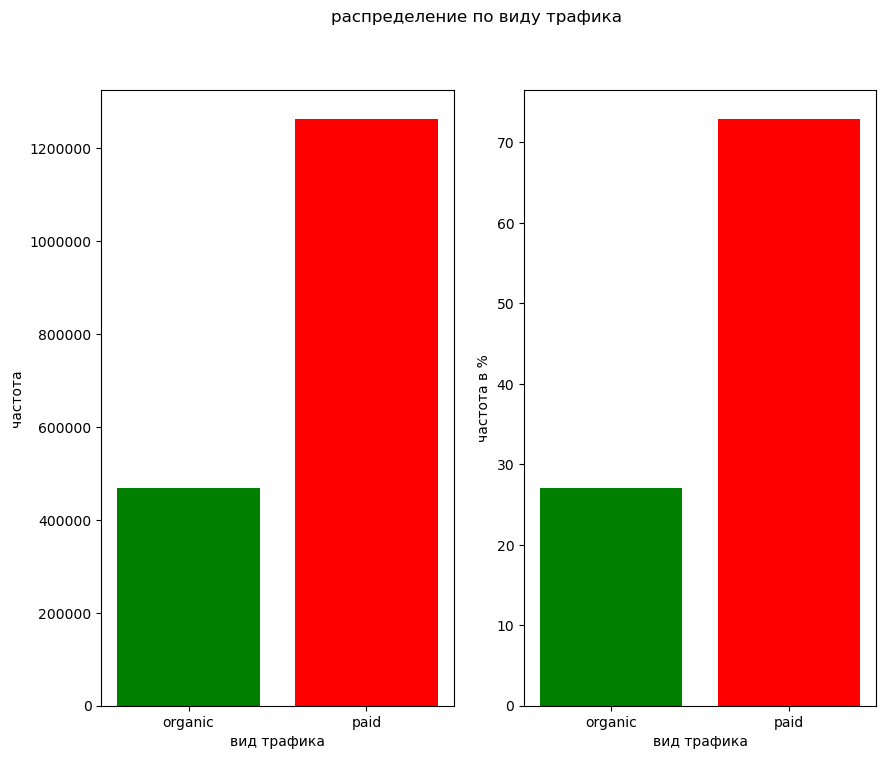

In [139]:
bar_graf(df=df_cleaned, 
         column='traffic', 
         xlabel='вид трафика', 
         title='распределение по виду трафика', 
         ylabel='частота')

_По большей части клиенты были привлечены благодаря платному трафику, нежели органическому, 73% против 27%._

Создадим столбчатую диаграмму распределения по категориям

  device_category    count  percent
0         desktop   346843     20.0
1          mobile  1368651     79.0
2          tablet    16696      1.0


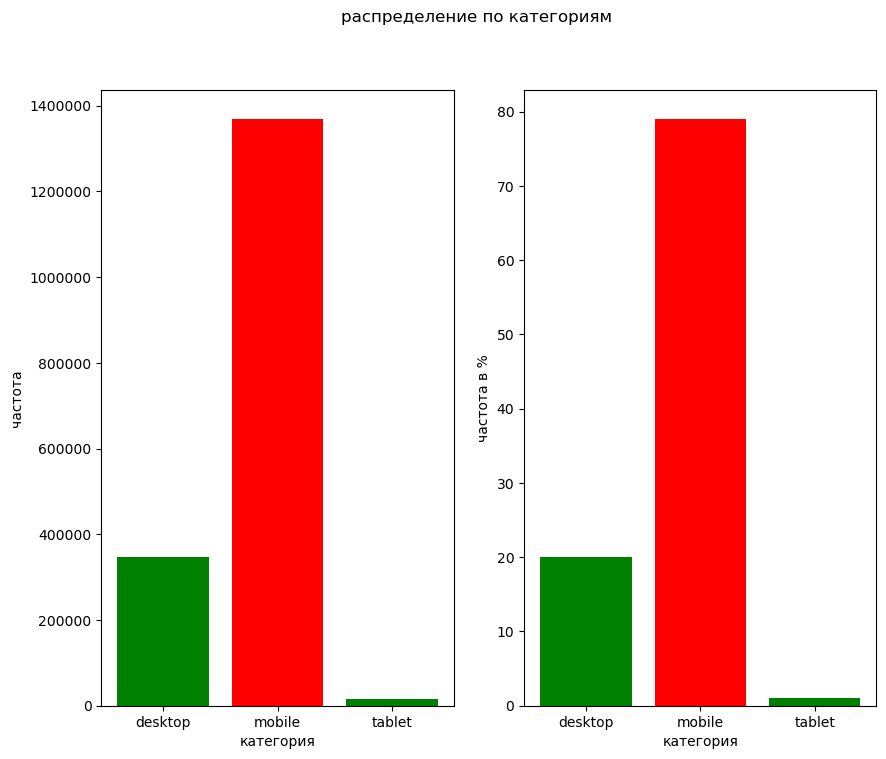

In [141]:
bar_graf(df=df_cleaned, 
         column='device_category', 
         xlabel='категория', 
         title='распределение по категориям', 
         ylabel='частота')

_Большая часть клиентов (79%) для входа на сайт использует мобильные устройства, реже настольные устройства, всего 20%._

# TEST TEST TEST TEST

In [81]:
df_cleaned.sample(5)

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target,advertising,traffic
615178,3503428829541301849.1621884506.1621884506,815705589.1621884505,2021-05-24,22:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,other,768x1024,Safari,Russia,Zheleznodorozhny,0,other,organic
1161051,5939507397636581335.1626269658.1626269658,1382899330.1626269655,2021-07-14,16:00:00,1,BHcvLfOaCWvWTykYqHVe,cpc,other,(none),mobile,Samsung,320x887,YaBrowser,Russia,(not set),0,other,paid
249963,1874743781694847589.1623931496.1623931496,436497801.1623931493,2021-06-17,15:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,mobile,Huawei,360x780,Chrome,Russia,Moscow,0,other,paid
1215165,6181997398596213415.1639406246.1639406246,1439358433.1639406247,2021-12-13,17:37:26,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,other,1440x900,Chrome,Russia,Moscow,0,other,organic
1450326,723096606772055103.1626364434.1626364912,168359048.1626360895,2021-07-15,19:00:00,3,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,Samsung,360x800,Chrome,Russia,Moscow,0,other,organic


In [82]:
len(df_cleaned.utm_campaign.unique().tolist())

407

In [83]:
df_cleaned.visit_number.value_counts()[20]

1126

In [84]:
pivot = df_cleaned.groupby(['visit_number'], as_index=False).session_id.count()
pivot = pivot.rename(columns={'session_id': 'count'})
pivot

,visit_number,count
0,1,1301099
1,2,212170
2,3,71823
3,4,36595
4,5,21480
...,...,...
528,559,1
529,561,1
530,562,1
531,563,1


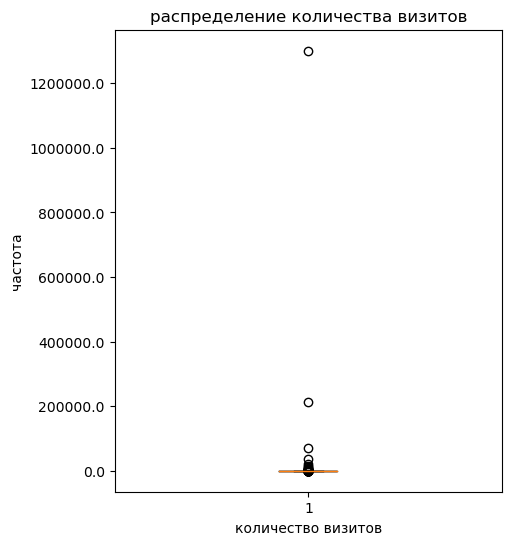

In [85]:
fig, ax = plt.subplots(figsize=(5, 6))
ax.boxplot(pivot['count'])
ax.set_xlabel('количество визитов')
ax.set_ylabel('частота')
ax.set_title('распределение количества визитов');
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

In [86]:
pivot['count'].describe().apply(lambda x: f'{x:0.3f}')

count        533.000
mean        3249.887
std        57184.933
min            1.000
25%            1.000
50%            9.000
75%           38.000
max      1301099.000
Name: count, dtype: object

In [87]:
pivot['count'].astype('str').describe()

count     533
unique    147
top         1
freq      197
Name: count, dtype: object

In [88]:
df_cleaned['visit_number'].astype('str').describe()

count     1732190
unique        533
top             1
freq      1301099
Name: visit_number, dtype: object

<AxesSubplot:>

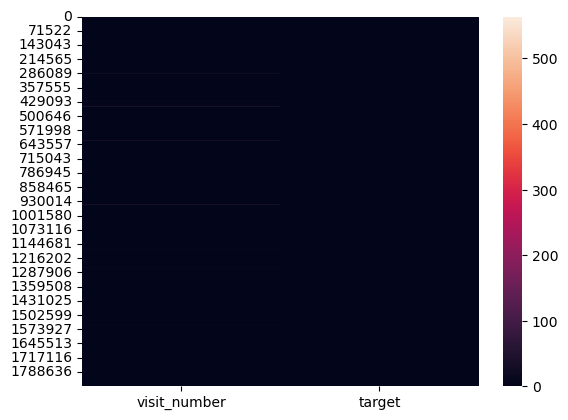

In [89]:
sns.heatmap(df_cleaned[['visit_number', 'target']])

In [90]:
df_cleaned['visit_number'].astype('str')

0          1
1          1
2          1
3          1
4          2
          ..
1860037    1
1860038    1
1860039    1
1860040    1
1860041    1
Name: visit_number, Length: 1732190, dtype: object